# Nonlinear Analysis Notebook
### Importing libraries

In [21]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import scipy.io
import os
import re
from utils import *
from sklearn.linear_model import LinearRegression

# Load the data into defined variables
#### note if there is some error loading a key, then comment it out and try to load data. 
#### sometimes keys of a data parameter may be saved with different name, print out all keys to figure out the required key

In [28]:
###############################################
runNumbers = [15]  # enter the run numbers to be loaded
#folder = '/sdf/data/lcls/ds/cxi/cxil1037623/hdf5/smalldata/' # insert here the directory path where .h5 files are stored
folder = '/sdf/data/lcls/ds/cxi/cxil1037623/hdf5/smalldata/'
###############################################
# (1) keys_to_combine: some keys loaded for each shot & stored per shot 
# (2) keys_to_sum: some keys loaded per each run and added 
# (3) keys_to_check : check if some keys exits and have same values in all runs and load these keys 
keys_to_combine = ['CXI-DG2-BMMON-WF/ROI_rebin_data',
                   #'CXI-DG2-BMMON-WF/ROI_area',
                    'jungfrau4M/azav_mask0_azav', # Unfiltered
                   'jungfrau4M/azav_mask1_azav', # Filtered
                   'ipm_dg2/sum',
                    #'ipm_dg3/sum',
                   #'ipm_hfx_dg2/sum',
                   'gas_detector/f_11_ENRC',
                   'ebeam/photon_energy',
                   'evr/code_183',
                   'evr/code_137',
                   'evr/code_141',
                   'lightStatus/xray',
                  #'CXI-DG2-BMMON-WF/cxi_dg2_bmmon_wf_rebin_data',
                  'jungfrau4M/Full_thres_sum',
                  'feeBld/hproj',
                  'lightStatus/laser',
                  #'dg2_traces'
                  ]

keys_to_sum = ['Sums/jungfrau4M_calib']
#               'Sums/jungfrau4M_calib_thresADU1']

keys_to_check = ['UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_q',
                'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_q',
                 'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_idxq',
                 'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_idxq',
                'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_qbin',
                'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_qbin',
                'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_qbins',
                'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_qbins',
                'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_userMask',
                'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_userMask',
                'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_matrix_q', # This are only needed once
                'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_matrix_phi', # This are only needed once
                'UserDataCfg/jungfrau4M/x',
                'UserDataCfg/jungfrau4M/y',
                'UserDataCfg/jungfrau4M/z',
                'UserDataCfg/jungfrau4M/cmask']
# Load the data in
data = combineRuns(runNumbers, folder, keys_to_combine, keys_to_sum, keys_to_check, verbose=False)  # this is the function to load the data with defined keys

# Filtered Data
azavFiltered = np.squeeze(data['jungfrau4M/azav_mask0_azav']) # I(q) : 1D azimuthal average of signals in each q bin
qbinFiltered = data['UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_qbin'] # q bin-size
qFiltered = data['UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_q'] # q bins 
qbinsFiltered = data['UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_qbins'] # q bins
userMaskFiltered = data['UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_userMask'].astype(bool) # User mask for this region
qbinSizeFiltered = np.bincount(data['UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_idxq'])
# Unfiltered Data
azav = np.squeeze(data['jungfrau4M/azav_mask1_azav']) # I(q) : 1D azimuthal average of signals in each q bin
qbin = data['UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_qbin'] # q bin-size
q = data['UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_q'] # q bins 
qbins = data['UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_qbins'] # q bins
userMask = data['UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_userMask'].astype(bool) # User mask for this region
qbinSize = np.bincount(data['UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_idxq'])
# Other Data
matrix_q = data['UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_matrix_q'].reshape(8,512,1024) # Q values J4M shaped
matrix_phi = data['UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_matrix_phi'].reshape(8,512,1024) # phi valyes J4M shaped
xrayOn = data['evr/code_137'].astype(bool)  # xray on events
xrayOn2 = data['lightStatus/xray'].astype(bool)  # xray on events
laserOn = data['lightStatus/laser'].astype(bool)  # xray on events
jungfrau_sum = data['Sums/jungfrau4M_calib']  # Total Jungfrau detector counts summed in a run
#jungfrau_sum = data['Sums/jungfrau4M_calib_thresADU1']   # Total Jungfrau detector counts with Thresholds added, summed in a run 
x = data['UserDataCfg/jungfrau4M/x'] # coordinates of Jungfrau detector x,y,z
y = data['UserDataCfg/jungfrau4M/y']
z = data['UserDataCfg/jungfrau4M/z'] 

cmask = data['UserDataCfg/jungfrau4M/cmask'].astype(bool) # Mask for detector created 
run_indicator = data['run_indicator'] # run indicator for each shot
# dg3 = data['ipm_dg3/sum']    # downstream diode x-ray intensity
# pressure = data['epicsAll/gasCell_pressure']  # pressure in gas cell
xray_energy = data['gas_detector/f_11_ENRC']   # xray energy from gas detector (not calibrated to actual values)
xray_eV = data['ebeam/photon_energy']    # x-ray energy energy in eV|
#dg2Trace = data['CXI-DG2-BMMON-WF/cxi_dg2_bmmon_wf_rebin_data']
numPhotons = data['jungfrau4M/Full_thres_sum']
spec = data['feeBld/hproj'] # Shot to shot spectrometer
#dg2traces = data['dg2_traces'][()][:,:,::8] # Dg2 traces, downsampled by a factor of 8
#dg2Sum = data['ipm_dg2/sum']
#dg2Sum = np.sum(np.sum(data['CXI-DG2-BMMON-WF/ROI_rebin_data'],axis=1),axis=1)
dg2traces = data['CXI-DG2-BMMON-WF/ROI_rebin_data'][()][:,:,::8] # Downsampling by a factor of 8, makes the refitting much better in the long run
#dg2tracesFull = data['CXI-DG2-BMMON-WF/ROI_rebin_data']
del data

# For some reason we need to offet the data by one. Will this be a problem in later experiments?
spec = spec[0:-2];
azavFiltered = azavFiltered[1:-1];
azav = azav[1:-1];
xrayOn = xrayOn[1:-1];
xrayOn2 = xrayOn2[1:-1];
laserOn = laserOn[1:-1];
dg2traces = dg2traces[1:-1];
#dg2tracesFull = dg2tracesFull[1:-1];
#dg2Sum = dg2Sum[1:-1];

Loading: /sdf/data/lcls/ds/cxi/cxil1037623/hdf5/smalldata/cxil1037623_Run0015.h5
Loaded Data


### Filtering out the bad shots

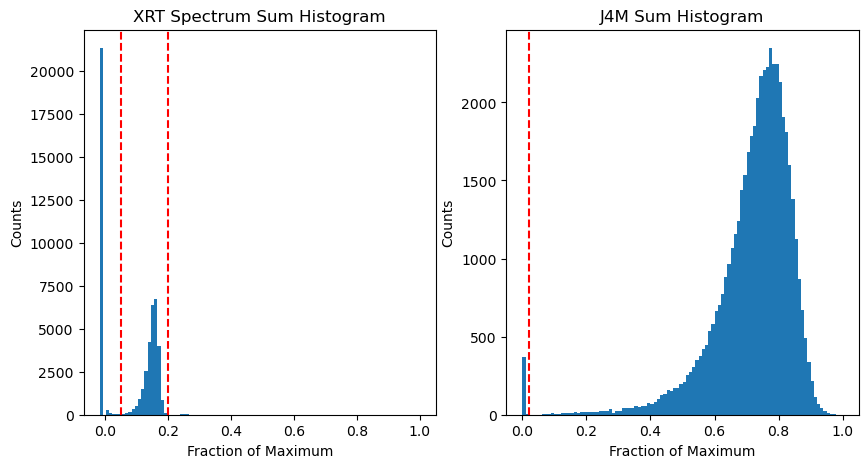

In [29]:
##########
integration_cutoff_hb = 0.2
integration_cutoff_lb = 0.05
scattering_cutoff = 0.02
##########
scattered_xrays = np.sum(azav*qbinSize,axis=-1)
scattered_xraysFiltered = np.sum(azavFiltered*qbinSizeFiltered,axis=-1)

int_spec = spec.sum(axis=1)

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.hist(int_spec/int_spec.max(),bins=100);
plt.axvline(integration_cutoff_lb,color='r',linestyle='--')
plt.axvline(integration_cutoff_hb,color='r',linestyle='--')
plt.title('XRT Spectrum Sum Histogram')
plt.xlabel('Fraction of Maximum')
plt.ylabel('Counts')
plt.subplot(1,2,2)
plt.hist(scattered_xrays/scattered_xrays.max(),bins=100)
plt.axvline(scattering_cutoff,color='r',linestyle='--')
plt.title('J4M Sum Histogram')
plt.xlabel('Fraction of Maximum')
plt.ylabel('Counts')
plt.show()
# Doing the actual filtering
goodSpecIdx = (int_spec/int_spec.max()>integration_cutoff_lb) & (int_spec/int_spec.max()<integration_cutoff_hb) & (xrayOn2) & (scattered_xrays/scattered_xrays.max()>scattering_cutoff)
specGood = spec[goodSpecIdx]

### Taking a look at the dg2 sum from the downsampled traces

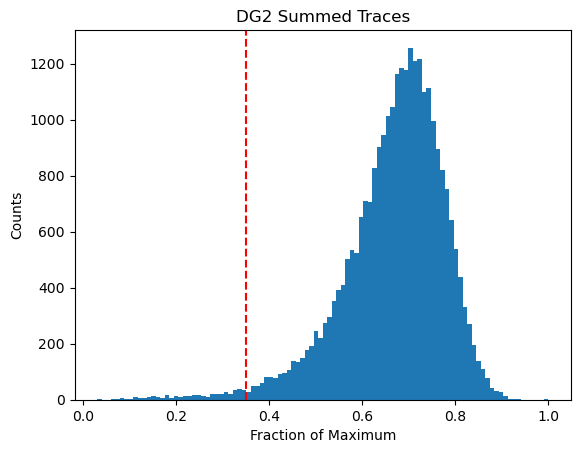

In [30]:
# Reworking the dg2 traces to have 0 offset and the direction is positive going
############
dg2Low = 0.35 # Mask cutoff for linearity
############
dg2Sum = [] # Empty the array
for trace in dg2traces[goodSpecIdx]:
    sumTrace = trace.sum(axis=0) # Sum the 8 traces from each diode
    baseline = sumTrace[0:5].mean() # Find the baseline by looking at the first few values
    dg2Sum.append(np.sum(-1*(sumTrace-baseline))) # Subtract the basline, invert the trace, sum it up for each shot
dg2Sum = np.array(dg2Sum) # Turn into a np array
plt.hist(dg2Sum/dg2Sum.max(),bins=100)
plt.axvline(dg2Low,color='r',linestyle='--')
plt.title('DG2 Summed Traces')
plt.xlabel('Fraction of Maximum')
plt.ylabel('Counts')
plt.show()
plt.show()

dg2LowIdx = ((dg2Sum/dg2Sum.max())<dg2Low) # Creating the mask

### Doing Ian's Dg2 refitting routine but only using the low intensity shots for the refitting

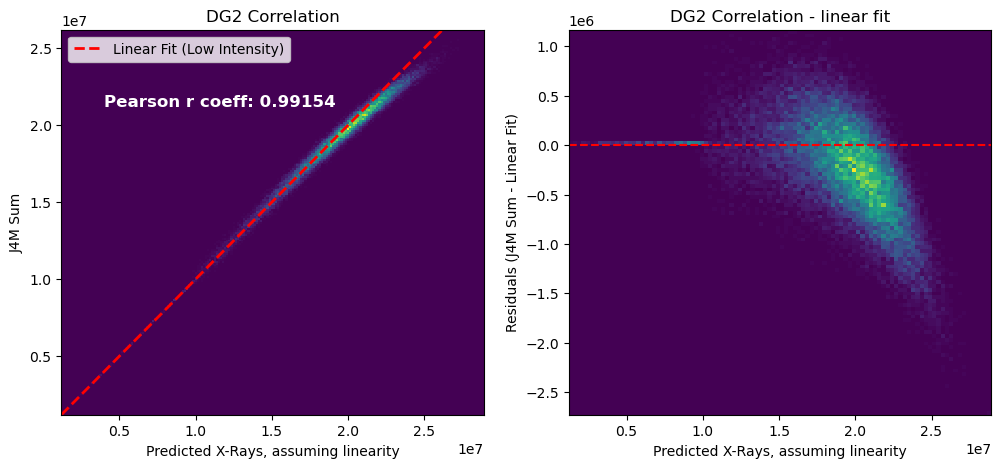

In [31]:
def fit_intensity_from_traces(traces, scattered_xrays, laserOn,fit_fraction=1):
    traces_flattened = traces.reshape(traces.shape[0],-1)
    fitIdx = (np.random.uniform(size=laserOn[dg2LowIdx].size)<fit_fraction)&(~laserOn[dg2LowIdx])
    x, residuals, rank, s = np.linalg.lstsq(traces_flattened[dg2LowIdx][fitIdx],scattered_xrays[dg2LowIdx][fitIdx],rcond=None)
   
    predicted_xrays = np.matmul(traces_flattened,x)
   
    return predicted_xrays

# scattered_xrays = np.sum(data['jungfrau4M/azav_azav'],axis=-1)
# plt.figure()
# for i in range(5):|
#     plt.plot(traces[i,0,:]+1000*i)
# plt.show()
predicted_xrays = fit_intensity_from_traces(dg2traces[goodSpecIdx],scattered_xrays[goodSpecIdx],np.zeros_like(laserOn[goodSpecIdx]))

fit_x = predicted_xrays[dg2LowIdx]
fit_y = scattered_xrays[goodSpecIdx][dg2LowIdx]

# Perform linear fit
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(fit_x, fit_y)

# Compute the predicted values based on the fit
fitted_values = slope * predicted_xrays + intercept

# Compute residuals
residuals = scattered_xrays[goodSpecIdx] - fitted_values

plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.hist2d(predicted_xrays,scattered_xrays[goodSpecIdx],bins=200);
plt.title('DG2 Correlation')
plt.xlabel('Predicted X-Rays, assuming linearity')
plt.ylabel('J4M Sum')

# Generate fit line
x_fit = np.linspace(np.min(predicted_xrays), np.max(predicted_xrays), 100)
y_fit = slope * x_fit + intercept

# Overlay the fit line
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Linear Fit (Low Intensity)',linestyle='--')
plt.legend()

rcoeff = scipy.stats.pearsonr(predicted_xrays,scattered_xrays[goodSpecIdx])
plt.text(0.1,0.8,f'Pearson r coeff: {rcoeff.statistic:.5f}',
         fontsize=12,fontweight='bold',transform=plt.gca().transAxes,ha='left',color='White')

# Plot the residual histogram in the second subplot
plt.subplot(1,2,2)
plt.hist2d(predicted_xrays, residuals, bins=100, cmap='viridis')
plt.axhline(0,linestyle='--',color='r')
plt.title('DG2 Correlation - linear fit')
plt.xlabel('Predicted X-Rays, assuming linearity')
plt.ylabel('Residuals (J4M Sum - Linear Fit)')
plt.show()


### Ghost imaging analysis for finding the spectrometer curve in the unfiltered region (This one takes a while)

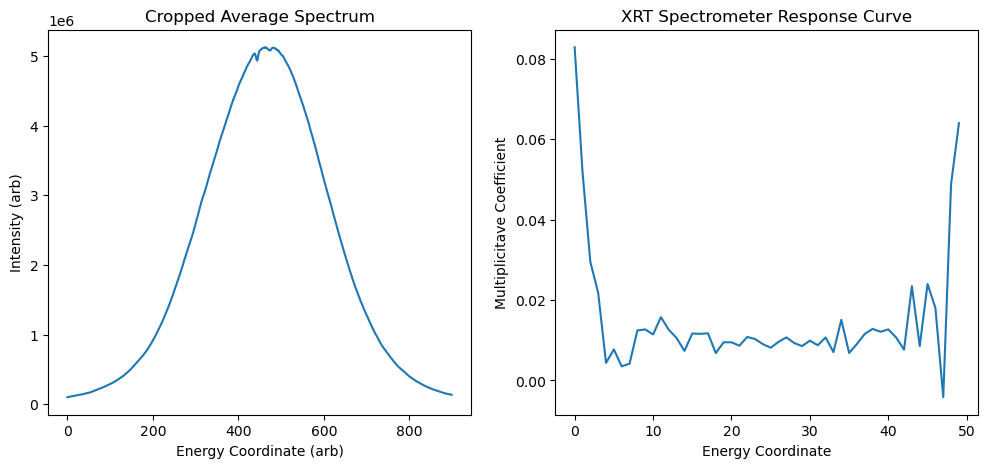

In [32]:
# Re-binning the spectrometer data on a shot-to-shot basis
specGood2 = specGood[:,600:1500]; # Cutting off spectrometer values
plt.figure(figsize=[12,5]);
plt.subplot(1,2,1)
plt.plot(specGood2.mean(axis=0))
plt.title('Cropped Average Spectrum')
plt.xlabel('Energy Coordinate (arb)')
plt.ylabel('Intensity (arb)')
###############
N=50 # New amount of bins. (original is 1100)
################
total_shots = specGood2.shape[0];
original_bins = specGood2.shape[1];
if original_bins % N != 0: # See if the new amount of bins are good
    raise ValueError("Number of original bins must be divisible by N.")
delta_N = specGood2.shape[1] // N; # Bin size


# Preallocate the rebinned spectrum
specGoodRebin = np.zeros((total_shots, N))

# Perform the rebinning
for i in range(total_shots):
    for j in range(N):
        sidx = j * delta_N
        eidx = (j + 1) * delta_N
        specGoodRebin[i, j] = np.sum(specGood2[i, sidx:eidx])
F_bright, residuals, rank, s = np.linalg.lstsq(specGoodRebin, scattered_xrays[goodSpecIdx], rcond=None)
plt.subplot(1,2,2)
plt.plot(F_bright)
plt.title('XRT Spectrometer Response Curve')
plt.xlabel('Energy Coordinate')
plt.ylabel('Multiplicitave Coefficient')
plt.show()

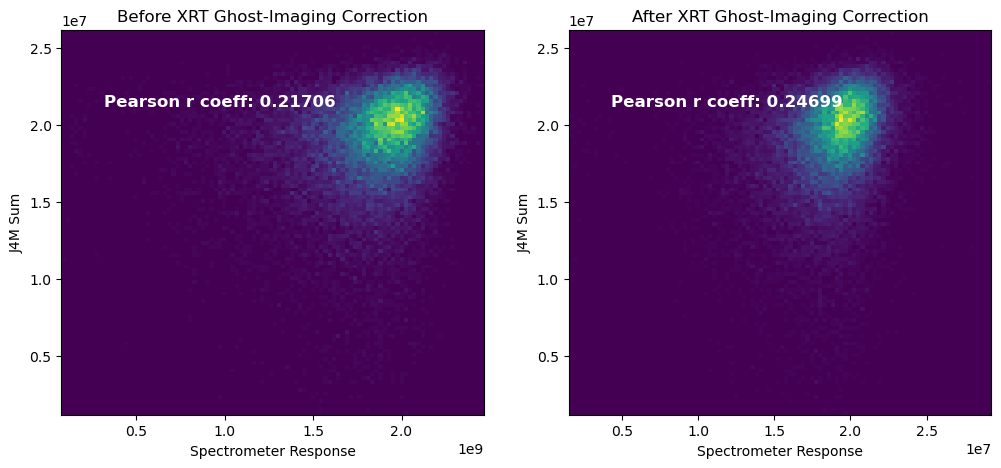

In [33]:
specCorrected = np.multiply(specGoodRebin,F_bright)
integratedSpecCorrected=specCorrected.sum(axis=1);
plt.figure(figsize=[12,5]);
plt.subplot(1,2,1)
counts, xedges, yedges, im = plt.hist2d(specGoodRebin.sum(axis=1),scattered_xrays[goodSpecIdx],100); # The counts variable will be used later.
plt.xlabel('Spectrometer Response');
plt.ylabel('J4M Sum');
plt.title('Before XRT Ghost-Imaging Correction')
rcoeff = scipy.stats.pearsonr(specGoodRebin.sum(axis=1),scattered_xrays[goodSpecIdx])
plt.text(0.1,0.8,f'Pearson r coeff: {rcoeff.statistic:.5f}',
         fontsize=12,fontweight='bold',transform=plt.gca().transAxes,ha='left',color='White')
plt.subplot(1,2,2)
counts, xedges, yedges, im = plt.hist2d(integratedSpecCorrected,scattered_xrays[goodSpecIdx],100); # The counts variable will be used later.
plt.xlabel('Spectrometer Response');
plt.ylabel('J4M Sum');
plt.title('After XRT Ghost-Imaging Correction')
rcoeff = scipy.stats.pearsonr(integratedSpecCorrected,scattered_xrays[goodSpecIdx])
plt.text(0.1,0.8,f'Pearson r coeff: {rcoeff.statistic:.5f}',
         fontsize=12,fontweight='bold',transform=plt.gca().transAxes,ha='left',color='White')
plt.show()

### Now to do the same ghost imaging but to apply the spectrometer filter function and take a look a the filtered section.

Text(0.5, 1.0, 'Average Filtered Signal')

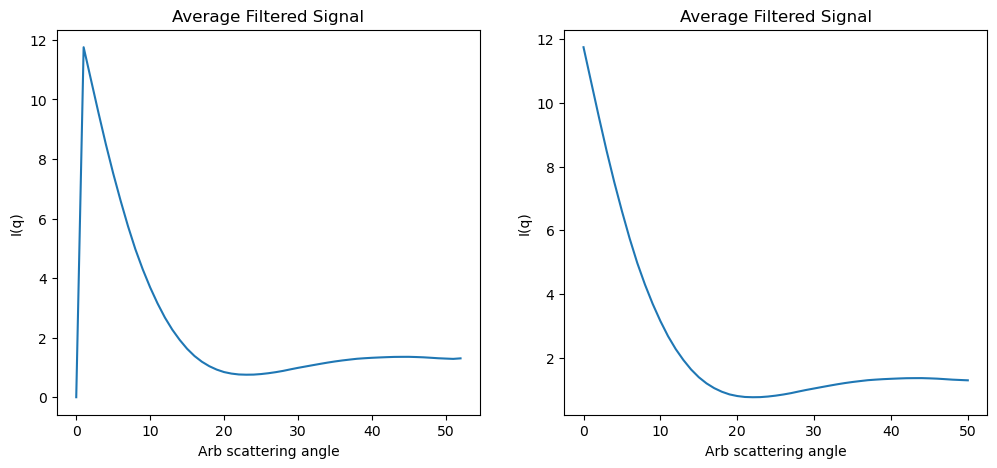

In [134]:
# plt.figure(figsize=[12,5])
# plt.subplot(1,2,1)
# plt.plot(azavFiltered[goodSpecIdx].mean(axis=0))
# plt.xlabel('Arb scattering angle')
# plt.ylabel('I(q)')
# plt.title('Average Filtered Signal')
# azavFilteredCropped = azavFiltered[:,1:-1]
# plt.subplot(1,2,2)
# plt.plot(azavFilteredCropped[goodSpecIdx].mean(axis=0))
# plt.xlabel('Arb scattering angle')
# plt.ylabel('I(q)')
# plt.title('Average Filtered Signal')

Text(0.5, 1.0, 'Filter Function')

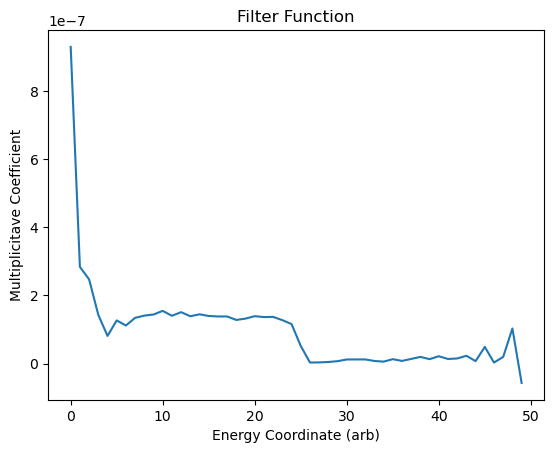

In [16]:
numShots, numEbins = specGoodRebin.shape
numQbins = azavFiltered.shape[1]

# Solve for F(E, q) using least squares
F_dim, residuals, rank, s = np.linalg.lstsq(specGoodRebin, azavFiltered[goodSpecIdx], rcond=None)

# F_dim now has shape (100, numQbins), representing energy vs. q dependence
#plt.figure(figsize=[12,5])
#plt.subplot(1,2,1)
#plt.pcolormesh(qbinsFiltered,np.arange(51), F_dim, shading='auto', cmap='viridis')
#plt.clim(-0.0000000001, 0.00000001)
#plt.colorbar()
#plt.xlabel("q")
#plt.ylabel("Energy bins")
#plt.title("Filter Function F(E, q)")
#plt.subplot(1,2,2)
plt.plot(F_dim.sum(axis=1))
plt.ylabel('Multiplicitave Coefficient')
plt.xlabel('Energy Coordinate (arb)')
plt.title('Filter Function')

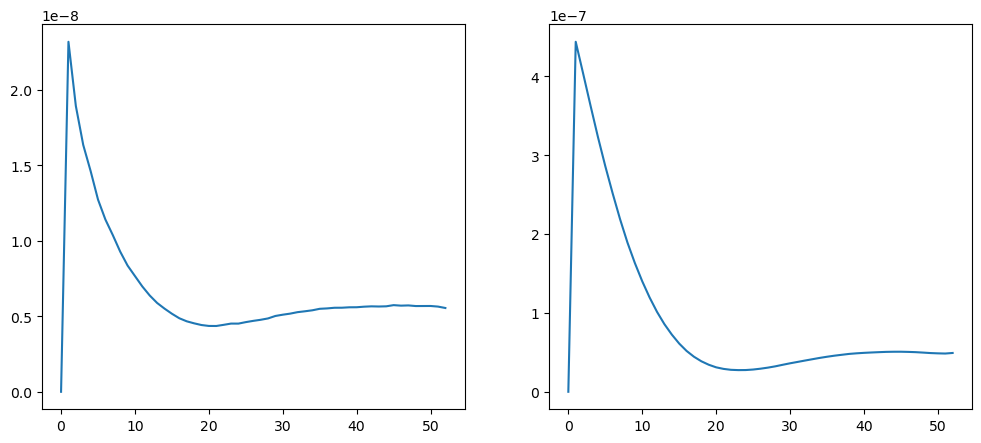

In [136]:
# plt.figure(figsize=[12,5])
# plt.subplot(1,2,1)
# plt.plot(F_dim[26:-1].sum(axis=0))
# plt.subplot(1,2,2)
# plt.plot(F_dim.sum(axis=0))

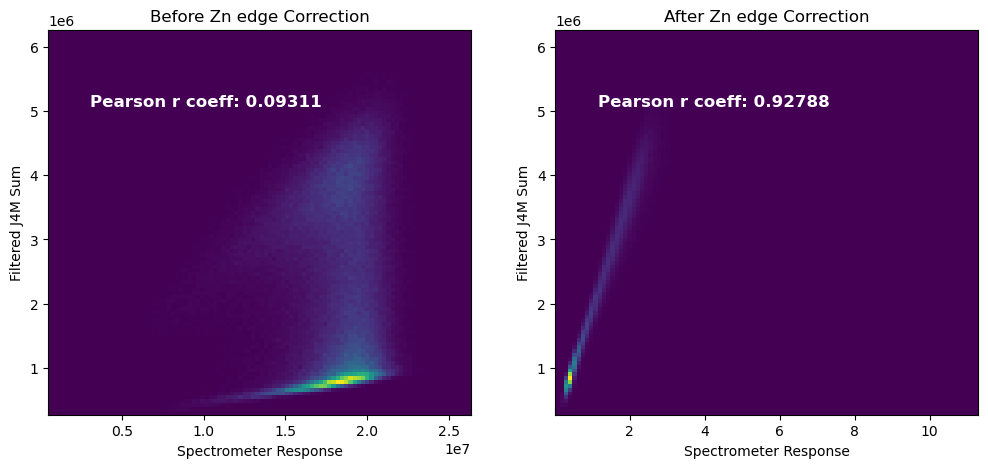

In [11]:
specCorrectedFiltered = np.multiply(specCorrected,F_dim.sum(axis=1))
integratedSpecCorrectedFiltered=specCorrectedFiltered.sum(axis=1);
plt.figure(figsize=[12,5]);
plt.subplot(1,2,1)
counts, xedges, yedges, im = plt.hist2d(specCorrected.sum(axis=1),scattered_xraysFiltered[goodSpecIdx],100); # The counts variable will be used later.
plt.xlabel('Spectrometer Response');
plt.ylabel('Filtered J4M Sum');
plt.title('Before Zn edge Correction')
rcoeff = scipy.stats.pearsonr(specCorrected.sum(axis=1),scattered_xraysFiltered[goodSpecIdx])
plt.text(0.1,0.8,f'Pearson r coeff: {rcoeff.statistic:.5f}',
         fontsize=12,fontweight='bold',transform=plt.gca().transAxes,ha='left',color='White')
plt.subplot(1,2,2)
counts, xedges, yedges, im = plt.hist2d(integratedSpecCorrectedFiltered,scattered_xraysFiltered[goodSpecIdx],100); # The counts variable will be used later.
plt.xlabel('Spectrometer Response');
plt.ylabel('Filtered J4M Sum');
plt.title('After Zn edge Correction')
rcoeff = scipy.stats.pearsonr(specCorrectedFiltered.sum(axis=1),scattered_xraysFiltered[goodSpecIdx])
plt.text(0.1,0.8,f'Pearson r coeff: {rcoeff.statistic:.5f}',
         fontsize=12,fontweight='bold',transform=plt.gca().transAxes,ha='left',color='White')
plt.show()

### Picking a threshold for the spectrometer cutoff

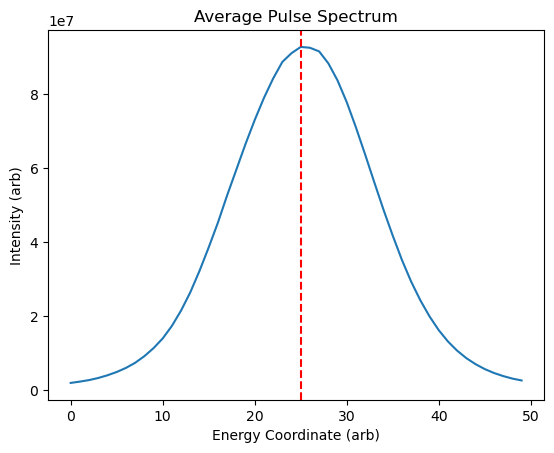

Cutoff = 25


In [138]:
averageSpectrum = np.mean(specGoodRebin,axis=0) # Taking the average of the spectra for the selected runs
spectrumCutoff = 25
plt.plot(averageSpectrum) # Plot the spectrum
plt.axvline(spectrumCutoff,color='r',linestyle='--') # Visualize the cutoff
plt.title('Average Pulse Spectrum')
plt.xlabel('Energy Coordinate (arb)')
plt.ylabel('Intensity (arb)')
plt.show()
print(f'Cutoff = {spectrumCutoff}')

### Calculating the peak ratios via the spectrometer readings

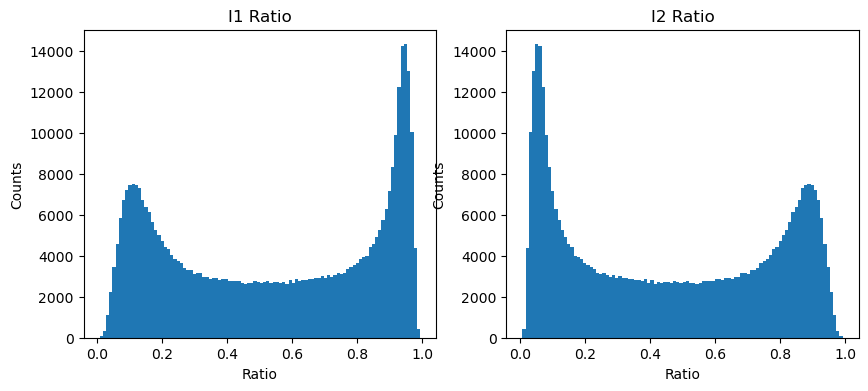

In [139]:
probe_int = specCorrected[:,0:spectrumCutoff].sum(axis=1)
I2Ratio = probe_int / integratedSpecCorrected
I1Ratio = 1 - I2Ratio

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.hist(I1Ratio,bins=100);
plt.title('I1 Ratio')
plt.xlabel('Ratio')
plt.ylabel('Counts')
plt.subplot(1,2,2)
plt.hist(I2Ratio,bins=100);
plt.title('I2 Ratio')
plt.xlabel('Ratio')
plt.ylabel('Counts')
plt.show()

### Looking at the total nonlinearity as a function of the dg2 reading

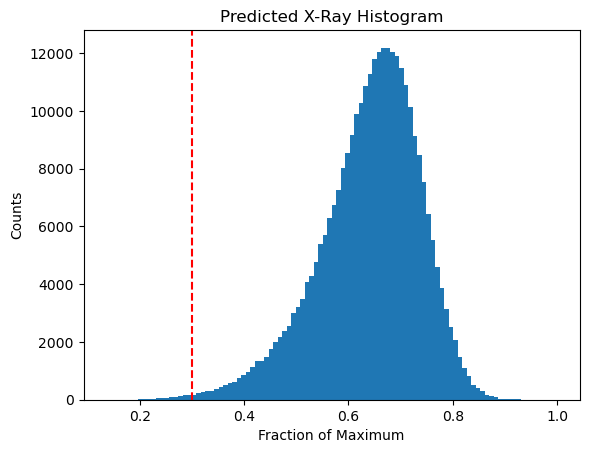

In [14]:
# Reworking the dg2 traces to have 0 offset and the direction is positive going
############
predXLow = 0.3 # Mask cutoff for linearity
############
plt.hist(predicted_xrays/predicted_xrays.max(),bins=100)
plt.axvline(predXLow,color='r',linestyle='--')
plt.title('Predicted X-Ray Histogram')
plt.xlabel('Fraction of Maximum')
plt.ylabel('Counts')
plt.show()
plt.show()

predXLowIdx = ((predicted_xrays/predicted_xrays.max())<predXLow) # Creating the predXLow

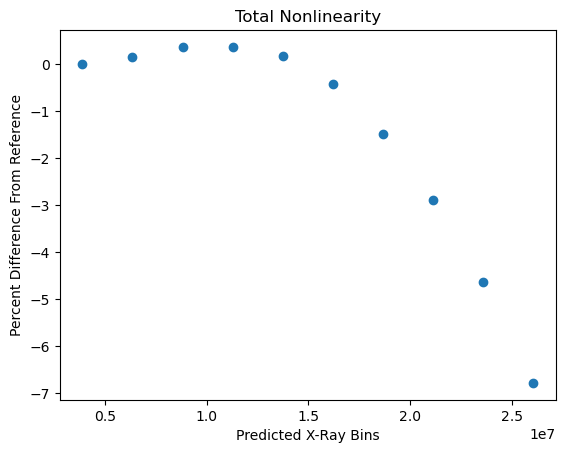

In [15]:
# Define bin edges (you can adjust the number of bins)
num_bins = 10  # Adjust as needed
bin_edges = np.linspace(predicted_xrays.min(), predicted_xrays.max(), num_bins + 1)

# Digitize dg2Sum to get bin indices
bin_indices = np.digitize(predicted_xrays, bin_edges) - 1  # Adjust for zero-based indexing

# Initialize an array to store averaged normAzav
binned_means = np.zeros(num_bins)

normParameter = 'dg2'

for i in range(num_bins):
    if i==0:
        refMask = bin_indices == i  # Get indices belonging to this bin
        if normParameter == 'dg2':
            linearRefSumNorm = (np.sum(azav[goodSpecIdx][refMask]*qbinSize,axis=1)/predicted_xrays[refMask]).mean(axis=0)
        elif normParameter == 'highq':
            linearRefSumNorm = (np.sum(azav[goodSpecIdx][refMask]*qbinSize,axis=1)/azav[goodSpecIdx][refMask][:,60:-1].sum(axis=1)).mean(axis=0)
    tempMask = bin_indices == i  # Get indices belonging to this bin
    if np.any(tempMask):  # Check if bin is not empty
        if normParameter == 'dg2':
            binned_means[i] = 100*(np.mean((azav[goodSpecIdx][tempMask]*qbinSize).sum(axis=1)/predicted_xrays[tempMask], axis=0)-linearRefSumNorm)/linearRefSumNorm
        elif normParameter == 'highq':
            binned_means[i] = 100*(np.mean((azav[goodSpecIdx][tempMask]*qbinSize).sum(axis=1)/azav[goodSpecIdx][tempMask][:,60:-1].sum(axis=1), axis=0)-linearRefSumNorm)/linearRefSumNorm
plt.plot(bin_edges[:-1],binned_means,'o')
plt.ylabel('Percent Difference From Reference')
plt.xlabel('Predicted X-Ray Bins')
plt.title('Total Nonlinearity')
plt.show()

### Looking at the q and intensity dependence of the total nonlinearity

/lscratch/davidjr/tmp/ipykernel_20233/3663272693.py:27: RuntimeWarning: invalid value encountered in divide
  binned_means[i] = 100 * (mean_value - linearRefSumNorm) / linearRefSumNorm


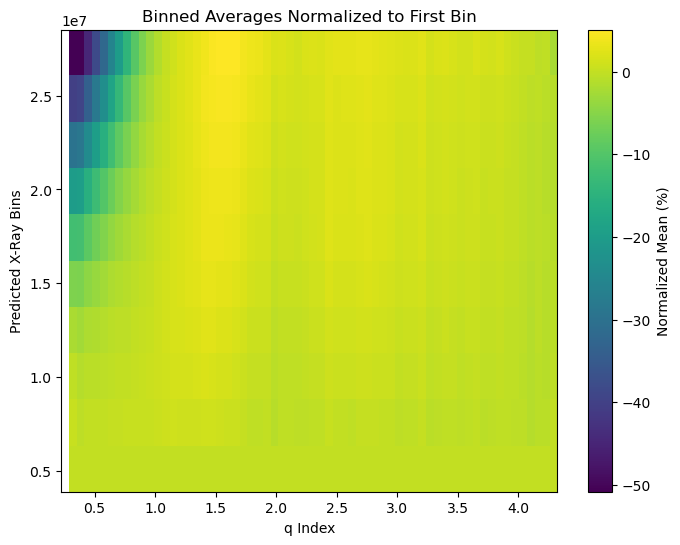

In [20]:

# Define bin edges (you can adjust the number of bins)
num_bins = 10  # Adjust as needed
bin_edges = np.linspace(predicted_xrays.min(), predicted_xrays.max(), num_bins + 1)

# Digitize dg2SumGood to get bin indices
bin_indices = np.digitize(predicted_xrays, bin_edges) - 1  # Adjust for zero-based indexing

# Initialize an array to store averaged normAzav
binned_means = np.zeros((num_bins, azav.shape[1]))

normParameter = 'dg2'

for i in range(num_bins):
    tempMask = bin_indices == i  # Get indices belonging to this bin
    if np.any(tempMask):  # Check if bin is not empty
        if normParameter == 'dg2':
            norm_factor = predicted_xrays[tempMask][:, np.newaxis]  # Reshape to (N,1) for broadcasting
            mean_value = np.mean((azav[goodSpecIdx][tempMask] * qbinSize) / norm_factor, axis=0)
        elif normParameter == 'highq':
            norm_factor = azav[goodSpecIdx][tempMask][:, 60:-1].sum(axis=1, keepdims=True)  # Reshape for broadcasting
            mean_value = np.mean((azav[goodSpecIdx][tempMask] * qbinSize) / norm_factor, axis=0)
        
        if i == 0:
            linearRefSumNorm = mean_value  # Store reference for normalization

        # Normalize using the first bin's mean as reference
        binned_means[i] = 100 * (mean_value - linearRefSumNorm) / linearRefSumNorm

# **Plot the data using a color plot**
plt.figure(figsize=(8, 6))
im = plt.imshow(binned_means, aspect='auto', extent=[qbins[0], qbins[-1], bin_edges[0], bin_edges[-1]], origin='lower')

# Add colorbar
plt.colorbar(im, label="Normalized Mean (%)")
#plt.clim(1,-15)
# Labels and Title
plt.xlabel("q Index")
plt.ylabel("Predicted X-Ray Bins")
plt.title("Binned Averages Normalized to First Bin")

plt.show()

### Extracting coeffs from the filtered section

In [115]:
I1 = I1Ratio*predicted_xrays
I2 = I2Ratio*predicted_xrays
X = np.column_stack([I1*I2,I2,I2**2])
model = LinearRegression()
model.fit(X, scattered_xraysFiltered[goodSpecIdx])
coefficients = model.coef_
intercept = model.intercept_
print(f"coeff_I1I2 = {coefficients[0]:.8f}, coeff_I2 = {coefficients[1]:.8f}, coeff_I2**2 = {coefficients[2]:.8f}")

coeff_I1I2 = 0.00000000, coeff_I2 = 0.19435568, coeff_I2**2 = 0.00000000


### Extracting coeffs from the unfiltered section

In [117]:
X = np.column_stack([I1*I2,I2,I2**2,I1**2,I1])
model = LinearRegression()
model.fit(X, scattered_xraysFiltered[goodSpecIdx])
coefficients = model.coef_
intercept = model.intercept_
print(f"coeff_I1I2 = {coefficients[0]:.8f}, coeff_I2 = {coefficients[1]:.8f}, coeff_I2**2 = {coefficients[2]:.8f}, coeff_I1**2 = {coefficients[3]:.8f}, coeff_I1 = {coefficients[4]:.8f}")

coeff_I1I2 = -0.00000000, coeff_I2 = 0.26826574, coeff_I2**2 = -0.00000000, coeff_I1**2 = -0.00000000, coeff_I1 = 0.03529326
